# PPP

Imports and set magics:

In [244]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
from matplotlib_venn import venn2
from scipy import stats


# autoreload modules when code is run
%load_ext autoreload
%autoreload 2
%pip install pandas-datareader

# user written modules
import dataproject

import pandas_datareader 
import datetime


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Note: you may need to restart the kernel to use updated packages.


# Read and clean data

Using the [pandas_datareader](https://pandas-datareader.readthedocs.io/en/latest/index.html) package we import data on inflation and exchange rates from FRED (Frederal Reserve Economic Data).

In [245]:
#Importing data form FRED

#CPI data (Growth rate previous period (year), Not Seasonally Adjusted)
CPI_CAN = 'CPALTT01CAA657N'
CPI_USA = 'CPALTT01USA659N'
CPI_UK = 'CPALTT01GBA659N'

# Exchange rate 
EX_CAN = 'AEXCAUS' #(Canadian Dollars to One U.S. Dollar, Not Seasonally Adjusted)
EX_UK = 'AEXUSUK' #(U.S. Dollars to One U.K. Pound Sterling, Not Seasonally Adjusted)



Using the datatime module we set a "*start*" date and a "*end*" date to clear the dataset from unnecessary obsevations.

In [246]:
# Need first to encode dates in a python friendly to specify the length of the desired time period. 
# Use the datetime module - it is the general way to handle dates in python. 
start = datetime.datetime(1990,1,1)
end = datetime.datetime(2020,1,1)
timespan = end - start # We can investigate the precise time span by just subtracting to time variables.
print('total number of days:', timespan.days) # The timespan object has a days attribute.

total number of days: 10957


First we Import data for the Inflation in a dataset call *inflation*

In [293]:
# Call the FRED api using pandas_datareader 
inflation = pandas_datareader.data.DataReader([CPI_USA, CPI_UK, CPI_CAN], 'fred', start, end)
inflation = inflation.rename(columns = {'CPALTT01USA659N':'CPI_USA','CPALTT01GBA659N':'CPI_CA','CPALTT01CAA657N':'CPI_UK'})
inflation.head()

,CPI_USA,CPI_CA,CPI_UK
DATE,,,
1990-01-01,5.397956,8.0,4.780477
1991-01-01,4.234964,7.5,5.625864
1992-01-01,3.028820,4.6,1.490133
1993-01-01,2.951657,2.6,1.865079
1994-01-01,2.607442,2.2,0.165563


Then we import the exchange rate data in a dataset called *exchange*

In [297]:
# Call the FRED api using pandas_datareader 
exchange = pandas_datareader.data.DataReader([EX_UK, EX_CAN], 'fred', start, end)
exchange = exchange.rename(columns = {'AEXUSUK':'USUK_EX','AEXCAUS':'CAUS_EX'})
exchange['USUK_EX'] = 1 / exchange['USUK_EX']

exchange.head()

,USUK_EX,CAUS_EX
DATE,,
1990-01-01,0.560507,1.1668
1991-01-01,0.565803,1.1460
1992-01-01,0.566155,1.2085
1993-01-01,0.665956,1.2902
1994-01-01,0.652784,1.3664


## Explore each data set

**Inflation data** :

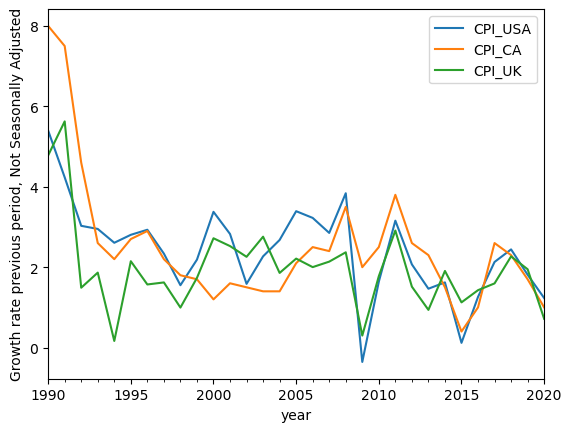

In [299]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)

# Now we are just plotting directly from the pandas dataframe. Still using matplotlib under the hood.
inflation.plot(ax=ax)

ax.legend(frameon=True)
ax.set_xlabel('year')
ax.set_ylabel('Growth rate previous period, Not Seasonally Adjusted');

We see here that the inflation in all three countries seems to follow each other.

**exchange rate data**

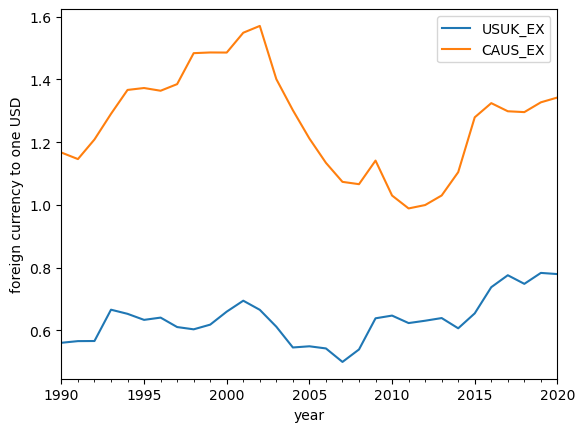

In [302]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)

# Now we are just plotting directly from the pandas dataframe. Still using matplotlib under the hood.
exchange.plot(ax=ax)

ax.legend(frameon=True)
ax.set_xlabel('year')
ax.set_ylabel('foreign currency for one USD');

There we see the exchange rate between Canada and the UK to USA respectively

# Merge data sets

Now we create combinations of your loaded data sets. we use a outer join to merge all the data in both dataset, and matches the data set on the "*DATE*" variable.

In [341]:
ppp = pd.merge(inflation, exchange, how = 'outer', on = ['DATE']);  
ppp.head()

,CPI_USA,CPI_CA,CPI_UK,USUK_EX,CAUS_EX
DATE,,,,,
1990-01-01,5.397956,8.0,4.780477,0.560507,1.1668
1991-01-01,4.234964,7.5,5.625864,0.565803,1.1460
1992-01-01,3.028820,4.6,1.490133,0.566155,1.2085
1993-01-01,2.951657,2.6,1.865079,0.665956,1.2902
1994-01-01,2.607442,2.2,0.165563,0.652784,1.3664


We now finde the pct. difference between the inflation in USA and i The UK and Canada, and the pct. difference between the exhange rate to the to countries and the US in each periode.

In [343]:
ppp['CA_pct_dif_from_USA_CPI'] = ((ppp.CPI_CA-ppp.CPI_USA) / ppp.CPI_USA) *10 # the pct. difference between inflation in canada and USA
ppp['UK_pct_dif_from_USA_CPI'] = ((ppp.CPI_UK-ppp.CPI_USA) / ppp.CPI_USA) *10 #the pct. difference between inflation in UK and USA
ppp['USUK_EX_DIF'] = (ppp['USUK_EX'].diff() / ppp['USUK_EX'].shift(1)) * 100 #tjek vejen
ppp['CAUS_EX_DIF'] = (ppp['CAUS_EX'].diff() / ppp['CAUS_EX'].shift(1)) * 100 #tjek vejen
ppp.head()

,CPI_USA,CPI_CA,CPI_UK,USUK_EX,CAUS_EX,CA_pct_dif_from_USA_CPI,UK_pct_dif_from_USA_CPI,USUK_EX_DIF,CAUS_EX_DIF
DATE,,,,,,,,,
1990-01-01,5.397956,8.0,4.780477,0.560507,1.1668,4.820423,-1.143913,NaN,NaN
1991-01-01,4.234964,7.5,5.625864,0.565803,1.1460,7.709714,3.284326,0.944891,-1.782653
1992-01-01,3.028820,4.6,1.490133,0.566155,1.2085,5.187434,-5.080153,0.062277,5.453752
1993-01-01,2.951657,2.6,1.865079,0.665956,1.2902,-1.191388,-3.681246,17.627864,6.760447
1994-01-01,2.607442,2.2,0.165563,0.652784,1.3664,-1.562611,-9.365037,-1.977936,5.906061


# Analysis

To get a quick overview of the data, we show some **summary statistics** on a meaningful aggregation. 

In [345]:
ppp.describe()

,CPI_USA,CPI_CA,CPI_UK,USUK_EX,CAUS_EX,CA_pct_dif_from_USA_CPI,UK_pct_dif_from_USA_CPI,USUK_EX_DIF,CAUS_EX_DIF
count,31.000000,31.000000,31.000000,31.000000,31.000000,31.000000,31.000000,30.000000,30.000000
mean,2.408992,2.500000,1.976641,0.635170,1.265181,-1.480875,0.376755,1.324723,0.626436
std,1.136639,1.641747,1.091014,0.073690,0.165603,13.179674,16.190032,6.879902,5.747049
min,-0.355546,0.400000,0.165563,0.499500,0.988700,-66.251470,-18.422724,-10.818331,-10.799796
25%,1.631133,1.550000,1.502906,0.584773,1.137600,-2.151948,-3.637896,-3.392761,-1.912476
50%,2.442583,2.200000,1.865079,0.633513,1.295700,-0.619189,-2.503279,0.818523,0.769386
75%,2.990238,2.600000,2.263310,0.662681,1.369450,2.121645,0.021242,5.034300,4.074278
max,5.397956,8.000000,5.625864,0.783208,1.570400,23.719098,84.855309,18.415171,15.829032


Here we check and remove outliers, which results in the filtered dataset called *filtered_ppp*

In [353]:
# Calculate z-scores for each data point
outlier_columns = ['CA_pct_dif_from_USA_CPI', 'UK_pct_dif_from_USA_CPI']
z_scores = stats.zscore(ppp[outlier_columns])
#print(z_scores)

# Define a threshold for z-score
threshold = 3  # Adjust this threshold as needed

# Filter out rows where the absolute z-score exceeds the threshold
filtered_ppp = ppp[((z_scores < threshold) & (z_scores > -threshold)).all(axis=1)] # removing for outliers
filtered_ppp = filtered_ppp.drop(filtered_ppp.index[0]) #removing the first row 
numbers_of_obs_before = ppp.describe().loc['count']
numbers_of_obs_after = filtered_ppp.describe().loc['count']

print(numbers_of_obs_before)
print(numbers_of_obs_after)


CPI_USA                    31.0
CPI_CA                     31.0
CPI_UK                     31.0
USUK_EX                    31.0
CAUS_EX                    31.0
CA_pct_dif_from_USA_CPI    31.0
UK_pct_dif_from_USA_CPI    31.0
USUK_EX_DIF                30.0
CAUS_EX_DIF                30.0
Name: count, dtype: float64
CPI_USA                    28.0
CPI_CA                     28.0
CPI_UK                     28.0
USUK_EX                    28.0
CAUS_EX                    28.0
CA_pct_dif_from_USA_CPI    28.0
UK_pct_dif_from_USA_CPI    28.0
USUK_EX_DIF                28.0
CAUS_EX_DIF                28.0
Name: count, dtype: float64


Here we see that there is 3 observation there was removed 

**graphical test for PPP**

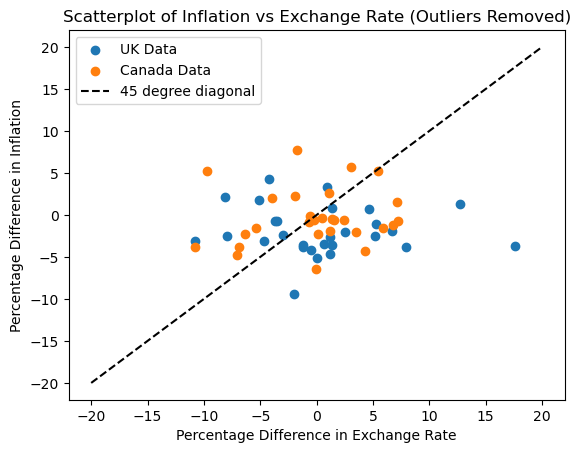

In [360]:
# Extract x and y values from the filtered dataset
filtered_pct_dif_infl_UKUS = filtered_ppp['UK_pct_dif_from_USA_CPI']
filtered_pct_dif_ex_UKUS = filtered_ppp['USUK_EX_DIF'] 
filtered_pct_dif_infl_CAUS = filtered_ppp['CA_pct_dif_from_USA_CPI']
filtered_pct_dif_ex_CAUS = filtered_ppp['CAUS_EX_DIF']
filtered_ppp['x_diagonal'] = np.linspace(-20, 20, 28)
filtered_ppp['y_diagonal'] = filtered_ppp['x_diagonal']

# Create a scatterplot
plt.scatter(filtered_pct_dif_ex_UKUS, filtered_pct_dif_infl_UKUS, label="UK Data")
plt.scatter(filtered_pct_dif_ex_CAUS, filtered_pct_dif_infl_CAUS, label="Canada Data")

# Add the diagonal line
plt.plot(filtered_ppp['x_diagonal'], filtered_ppp['y_diagonal'], color='black', linestyle='--', label='45 degree diagonal')

# Add labels and title
plt.xlabel('Percentage Difference in Exchange Rate')
plt.ylabel('Percentage Difference in Inflation')
plt.title('Scatterplot of Inflation vs Exchange Rate (Outliers Removed)')


# Add legend
plt.legend()

# Show the plot
plt.show()

We see that there may be a correlation in percentage differences in the exchange rates and the percentage differences in the inflation rates. 
If PPP were to hold, the changes in the exchange rates should equal the changes in the inflation rates. If this was true the data points would be placed directly on the 45 degree line in the scatterplot. 

**Five year average**

Due to pricestickyness, we may see a lack of comvergence towards ppp in the short run. We attempt to take this into consideration by dividing our datapoints into 5 year averages. 

In [363]:
# Define the time intervals
intervals = [
    (ppp.index[0], ppp.index[4]),
    (ppp.index[5], ppp.index[9]),
    (ppp.index[10], ppp.index[14]),
    (ppp.index[15], ppp.index[18]),
    (ppp.index[19], ppp.index[22]),
    (ppp.index[23], ppp.index[28])
]

# Create an empty list to store the mean values for each interval
mean_values = []

mean_year_mean_UK_pct_dif_from_USA_CPI = []
mean_year_mean_CA_pct_dif_from_USA_CPI = []
mean_year_mean_USUK_EX_DIF = []
mean_year_mean_CAUS_EX_DIF = []

# Iterate over the intervals
for interval in intervals:
    start_date, end_date = interval
    
    # Filter the DataFrame for the current interval
    filtered_interval = ppp.loc[start_date:end_date]
    
    
    # Calculate the mean for the current interval
    five_year_mean_UK_pct_dif_from_USA_CPI = filtered_interval['UK_pct_dif_from_USA_CPI'].mean()
    five_year_mean_CA_pct_dif_from_USA_CPI = filtered_interval['CA_pct_dif_from_USA_CPI'].mean()
    five_year_mean_USUK_EX_DIF = filtered_interval['USUK_EX_DIF'].mean()
    five_year_mean_CAUS_EX_DIF = filtered_interval['CAUS_EX_DIF'].mean()


    # Append the mean value to the list
    mean_year_mean_UK_pct_dif_from_USA_CPI.append(five_year_mean_UK_pct_dif_from_USA_CPI)
    mean_year_mean_CA_pct_dif_from_USA_CPI.append(five_year_mean_CA_pct_dif_from_USA_CPI)
    mean_year_mean_USUK_EX_DIF.append(five_year_mean_USUK_EX_DIF)
    mean_year_mean_CAUS_EX_DIF.append(five_year_mean_CAUS_EX_DIF)

# Print the mean values for each interval
print(mean_year_mean_UK_pct_dif_from_USA_CPI, mean_year_mean_CA_pct_dif_from_USA_CPI, mean_year_mean_USUK_EX_DIF, mean_year_mean_CAUS_EX_DIF)

[-3.1972047929675904, -3.1405572912760524, 0.06323900591277036, -3.399880405550572, -5.2597821534008675, 13.520336875127152] [2.992714532322251, -0.34116356987822005, -3.9862096189273934, -2.1326932312015723, -14.101553508343656, 4.702645330956669] [4.164273897991913, -1.0433276732793044, -2.221787499875176, -0.130997628774715, 4.3206022080169095, 3.0778585253356057] [4.0844016702959145, 1.7269705559602175, -2.44777625134117, -4.839935502600209, -1.4014920345906159, 4.5773643612289625]


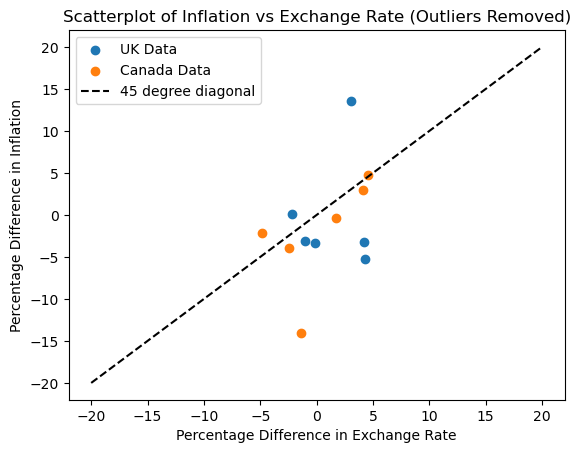

In [364]:
# Create a scatterplot
plt.scatter(mean_year_mean_USUK_EX_DIF, mean_year_mean_UK_pct_dif_from_USA_CPI, label="UK Data")
plt.scatter(mean_year_mean_CAUS_EX_DIF, mean_year_mean_CA_pct_dif_from_USA_CPI, label="Canada Data")


x_index = np.linspace(-20, 20, 50)
y_index = x_index
# Add the diagonal line
plt.plot(x_index, y_index, color='black', linestyle='--', label='45 degree diagonal')

# Add labels and title
plt.xlabel('Percentage Difference in Exchange Rate')
plt.ylabel('Percentage Difference in Inflation')
plt.title('Scatterplot of Inflation vs Exchange Rate (Outliers Removed)')

# Add legend
plt.legend()

# Show the plot
plt.show()

We now see that the data points is closer to the 45 degree diagonal, which could imply that PPP is more likely to hold in the long run than in the short run. 

# Conclusion

In the project we have imported data from FRED on Inflation and exchange rates for the countries USA, the UK and Canada. We merge the data into the dato set *ppp* which we then cleared for the data we should not use. Then we used the data to graphical analyses of the PPP, looking at den difference between inflation in each country and the difference between the exchange rate between the counties. There we found imlications that PPP may hold in the long run. 